# To-Dos: 
- Korrelationsanalyses

In [ ]:
## Datensatz 'San Francisco Crime Classification' von Kaggle
## Datensatzbeschreibung:
# Datum                         - Zeitpunkt der Straftat
# Kategorie                     - Kategorie der Straftat (nur in Trainingsdaten), Zielvariable
# Beschreibung                  - detaillierte Beschreibung der Straftat (nur in Trainingsdaten)
# Tag der Woche
# 'District' der Polizeistation - Name des 'Districts' der Polizeistation
# Auflösung                     - Ergebniss der Straftat
# Adresse                       - geschätzte Adresse der Straftat
# X                             - Long
# Y                             - Lat

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Import der Pakete
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
import matplotlib.pyplot as plt

In [5]:
# Einlesen der Trainings- und Testdaten
train = pd.read_csv("/content/drive/MyDrive/Master/DM/SF-Project/data/train.csv")
test  = pd.read_csv("/content/drive/MyDrive/Master/DM/SF-Project/data/test.csv")

In [ ]:
# Pauls Kasten
#train = pd.read_csv("/content/drive/MyDrive/Uni/Master/2.Semester/DataMining/Data/train.csv")
#test  = pd.read_csv("/content/drive/MyDrive/Uni/Master/2.Semester/DataMining/Data/test.csv")

In [6]:
# Übersicht über Kopf der Trainingsdaten
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [7]:
# Datentypen ermitteln
train.dtypes

Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

In [ ]:
train.shape

(878049, 9)

# **Datenvorverarbeitung**
- Trennung der Datenspalte
- NA Behandlung
- Duplikate entfernen
- Einschränkung der Kategorien

In [8]:
## Datenformatierung - Dates
# Umwandeln in Datumformat
train['Dates'] = pd.to_datetime(train['Dates'])
# Trennung von Datum und Uhrzeit
train['Date'] = train['Dates'].dt.strftime('%Y-%m-%d')
train['Date'] = pd.to_datetime(train['Date'])

train['Time'] = train['Dates'].dt.strftime('%H:%M')
train['Hour'] = pd.to_datetime(train['Dates'], format='%H:%M').dt.hour

In [20]:
# Jahr, Monat, Tag extrahieren
train['Year']  = train['Dates'].dt.strftime('%Y').astype(int)
train['Month'] = train['Dates'].dt.strftime('%m').astype(int)
train['Day']   = train['Dates'].dt.strftime('%d').astype(int)

In [21]:
# Variable WeekOfYear anlegen
train['WeekOfYear'] = pd.to_datetime(train['Date']).dt.isocalendar().week.astype(int)

In [11]:
# Variable Dates löschen
#train = train.drop('Dates',axis=1)

In [22]:
## NA Behandlung
# Übersicht über NA in Spalten
train.isna().sum()
# keine NA's ersichtlich 

Dates         0
Category      0
Descript      1
DayOfWeek     1
PdDistrict    1
Resolution    1
Address       1
X             1
Y             1
Date          0
Time          0
Hour          0
Year          0
Month         0
Day           0
WeekOfYear    0
dtype: int64

In [23]:
# Ausgabe eindeutiger Werte für relevanten Spalten
train_uniq = train.loc[:,['Category','PdDistrict','Resolution','Address']]
for col in train_uniq:
  print(train_uniq[col].value_counts())

LARCENY/THEFT                  53362
OTHER OFFENSES                 28138
NON-CRIMINAL                   28090
ASSAULT                        18107
VANDALISM                      10452
VEHICLE THEFT                   9889
WARRANTS                        9862
BURGLARY                        8833
DRUG/NARCOTIC                   8520
SUSPICIOUS OCC                  7927
MISSING PERSON                  6530
ROBBERY                         5702
FRAUD                           4060
SECONDARY CODES                 2764
WEAPON LAWS                     2236
TRESPASS                        1712
STOLEN PROPERTY                 1536
FORGERY/COUNTERFEITING          1257
SEX OFFENSES FORCIBLE           1156
DRUNKENNESS                     1058
PROSTITUTION                     786
KIDNAPPING                       688
DISORDERLY CONDUCT               629
RECOVERED VEHICLE                570
DRIVING UNDER THE INFLUENCE      551
ARSON                            377
RUNAWAY                          331
L

In [14]:
# Augenscheinlich keine fehlerhaften/uneindeutige Werte enthalten

In [24]:
## Duplikate
# Anzahl der Duplikate
dup_rows = train.duplicated()
print('Anzahl an duplizierten Zeilen:',sum(dup_rows))

Anzahl an duplizierten Zeilen: 0


In [16]:
# Entfernen der Duplikate
train        = train.drop_duplicates()
dup_rows_new = train.duplicated()
print('Anzahl an duplizierten Zeilen:',sum(dup_rows_new))

Anzahl an duplizierten Zeilen: 0


In [28]:
## Datenformatierung - Category
# Übersicht über Verbrechenskategorien
train['Category'].unique()

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT',
       'VEHICLE T'], dtype=object)

In [29]:
##Anzahl der verschiedenen Verbrechenskategorien 
count = len(train['Category'].unique())
print('Anzahl Kategorien:',count)

Anzahl Kategorien: 40


In [30]:
# Filtern der benötigten Kategorien
imp_cat   = ['LARCENY/THEFT','ASSAULT','DRUG/NARCOTIC','VEHICLE THEFT','BURGLARY']
train_sub = train[train['Category'].isin(imp_cat)]

In [31]:
train_sub['Category'].unique()

array(['LARCENY/THEFT', 'VEHICLE THEFT', 'ASSAULT', 'BURGLARY',
       'DRUG/NARCOTIC'], dtype=object)

# **Deskriptive Analyse**


Text(0.5, 1.0, 'Correlation Heatmap')

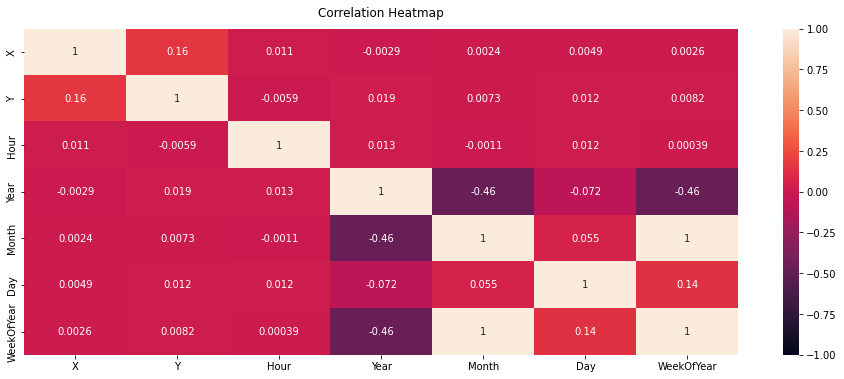

In [33]:
## Korrelationsanalyse Heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train.corr(), vmin=-1,vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [36]:
from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

train_cat = train[['Category','Descript','PdDistrict','Resolution']]

Korrelationsanalyse von nominal kategorischen Merkmalen, ohne Addresse aufgrund des geringen Rams in Colab. 
Description und Category sind hoch korreliert, was jedoch nicht weiter verwunderlich ist. Der Rest ist unauffällig.

In [38]:
rows= []

for var1 in train_cat:
  col = []
  for var2 in train_cat :
    cramers =cramers_V(train_cat[var1], train_cat[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = train_cat.columns, index =train_cat.columns)



df

,Category,Descript,PdDistrict,Resolution
Category,1.00,1.00,0.01,0.08
Descript,1.00,1.00,0.03,0.17
PdDistrict,0.01,0.03,1.00,0.01
Resolution,0.08,0.17,0.01,1.00


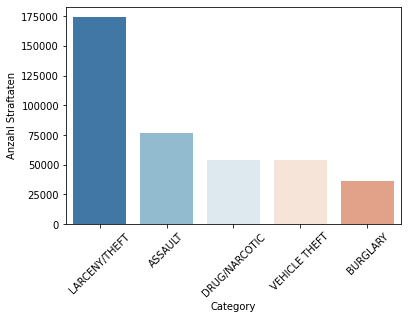

In [ ]:
## Verteilung Straftaten
sns.set_palette('RdBu_r')
sns.countplot(x='Category',
              data=train_sub,
              order = train_sub['Category'].value_counts().index)
plt.ylabel('Anzahl Straftaten')
plt.xticks(rotation=45)
plt.show()

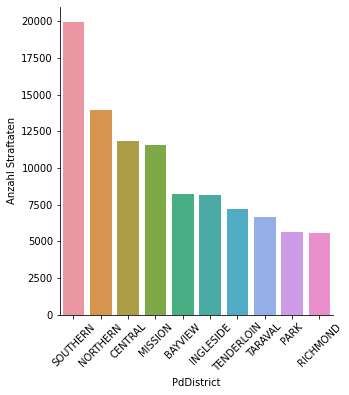

In [40]:
## Anzahl der Straftaten je Revier
sns.set_palette('RdBu_r')
k = sns.catplot(x='PdDistrict',
            data=train_sub,
            order=train_sub['PdDistrict'].value_counts().index,
            kind='count')
k.set_ylabels('Anzahl Straftaten')
plt.xticks(rotation=45)
plt.show()

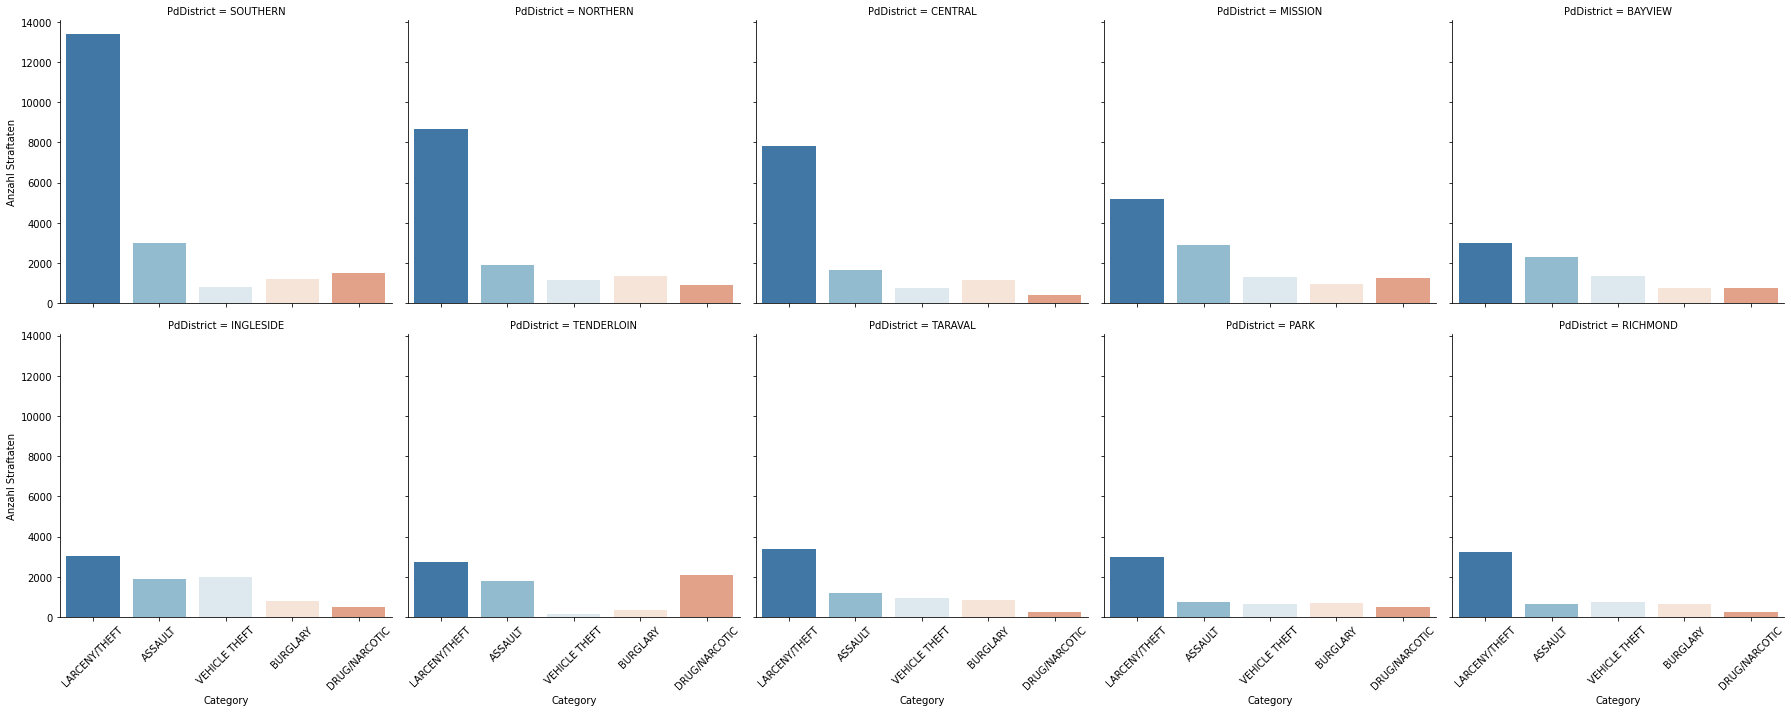

In [41]:
## Verteilung der Straftatsarten je Revier
sns.set_palette('RdBu_r')
g = sns.catplot(x='Category',
              data=train_sub,
            kind='count',
              order = train_sub['Category'].value_counts().index,
            col='PdDistrict',
            col_wrap=5,
            col_order=train_sub['PdDistrict'].value_counts().index)
g.set_ylabels('Anzahl Straftaten')
for ax in g.axes:
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45)
g.tight_layout()
plt.show()

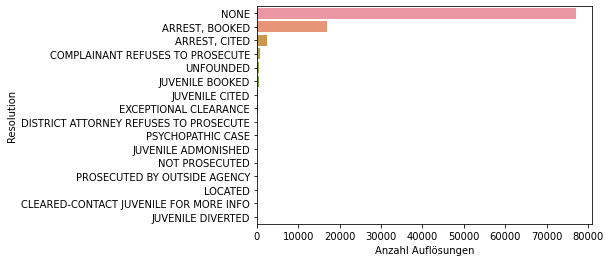

In [42]:
## Verteilung Auflösungen
sns.set_palette('RdBu_r')
sns.countplot(y='Resolution',
              data=train_sub,
              order = train_sub['Resolution'].value_counts().index)
plt.xlabel('Anzahl Auflösungen')
#plt.xticks(rotation=90)
plt.show()

In [43]:
## Zusammenführen der geringen Resolution Ausprägungen
top_res = train_sub.groupby(['Resolution']).size().reset_index(name='counts')
top_res = top_res.sort_values(by='counts',ascending=False)
top_res_names = top_res.iloc[0:4,0].tolist()
top_res_names

['NONE', 'ARREST, BOOKED', 'ARREST, CITED', 'COMPLAINANT REFUSES TO PROSECUTE']

In [44]:
## Alle Ausprägungen mit geringer Anzahl werden zusammengefasst
train_sub_red = train_sub
train_sub_red['Resolution'].mask(~train_sub_red['Resolution'].isin(top_res_names), 'OTHER', inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [45]:
train_sub_red.groupby('Resolution').size()

Resolution
ARREST, BOOKED                      16918
ARREST, CITED                        2387
COMPLAINANT REFUSES TO PROSECUTE      691
NONE                                77043
OTHER                                1672
dtype: int64

([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

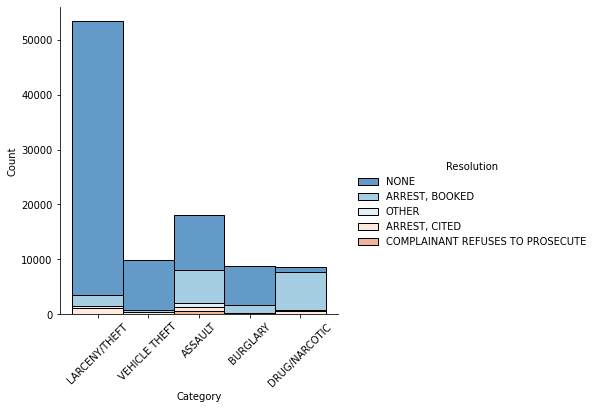

In [47]:
sns.displot(train_sub, x='Category', hue='Resolution', multiple='stack')
plt.xticks(rotation=45)

# **Feature Engineering**

1. Boolean Feature Sonne untergegangen 
2. Boolean Feature Wochenende/Feiertag 

In [48]:
#Sonnenauf -und untergänge in San Francisco auf monatlicher Basis
sunset = pd.read_csv("/content/drive/MyDrive/Master/DM/SF-Project/data/SunsetSF.csv",delimiter =';')
sunset['Month']=sunset['Month'].astype(int)



FileNotFoundError: ignored

In [ ]:
#train = pd.merge(train,sunset,how="left",on='Month')
#train.head()

In [ ]:
#conditions = [(train['Time']<train['Rise'])&(train['Time']>train['Set'])
  #            ,(train['Time']>train['Rise'])&(train['Time']<train['Set'])]
#values = [1,2]
#train['sunDown'] = np.where((train['Time']>train['Rise']),False,True)

In [ ]:
!pip3 install https://pypi.lcsb.uni.lu/packages/86/05/25c772065bb6384789ca0f6ecc9d0bdd0bc210064e5c78453ee15124082e/astral-1.10.1.tar.gz#sha256=d2a67243c4503131c856cafb1b1276de52a86e5b8a1d507b7e08bee51cb67bf1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://pypi.lcsb.uni.lu/packages/86/05/25c772065bb6384789ca0f6ecc9d0bdd0bc210064e5c78453ee15124082e/astral-1.10.1.tar.gz (53 kB)


In [ ]:
from astral import Astral
import pytz
import datetime

city_name = 'San Francisco'
a = Astral()
a.solar_depression = 'civil'
city = a[city_name]
for x in train['Dates']:
  sun = city.sun(date=x, local=True)
  x = datetime.datetime.utcnow().replace(tzinfo=pytz.UTC)
  if x >= sun['sunset'] or x <= sun['sunrise']:
    train['isDown']=True
  else: 
    train['isDown']=False




KeyboardInterrupt: ignored

In [ ]:
train.sample(100).head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Date,Time,Hour,Year,Month,Day,WeekOfYear,isDown
17403,2015-02-19 09:55:00,NON-CRIMINAL,"CIVIL SIDEWALKS, WARNING",Thursday,MISSION,NONE,400 Block of CASTRO ST,-122.435150,37.761760,2015-02-19,09:55,9,2015,2,19,8,True
563630,2007-05-30 11:58:00,ASSAULT,THREATS AGAINST LIFE,Wednesday,MISSION,NONE,400 Block of VALENCIA ST,-122.421935,37.766134,2007-05-30,11:58,11,2007,5,30,22,True
174097,2013-01-23 21:20:00,ROBBERY,ATTEMPTED ROBBERY ON THE STREET WITH BODILY FORCE,Wednesday,TARAVAL,NONE,SUNSET BL / JUDAH ST,-122.495751,37.760872,2013-01-23,21:20,21,2013,1,23,4,True
317141,2010-12-29 19:00:00,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,Wednesday,MISSION,NONE,100 Block of COLLINGWOOD ST,-122.436103,37.760004,2010-12-29,19:00,19,2010,12,29,52,True
626655,2006-06-26 18:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / MISSION ST,-122.406482,37.782732,2006-06-26,18:30,18,2006,6,26,26,True
